In [52]:
# #1) Скачиваем с https://fasttext.cc/docs/en/crawl-vectors.html
# #2) Распаковыпаем

# import gzip
# import shutil

# with gzip.open('cc.ru.300.bin.gz', 'rb') as f_in:
#     with open('cc.ru.300.bin', 'wb') as f_out:
#         shutil.copyfileobj(f_in, f_out)

### Подготовка 

In [53]:
import pandas as pd
import numpy as np
import fasttext
import fasttext.util
from tqdm import tqdm
import pickle
import ast

In [54]:
data = pd.read_csv('students_vacancies_10Nov2023.csv')

In [55]:
data = data.drop(['id','salary_to'], axis=1)

top_5_city = data.city_id.value_counts().reset_index()['city_id'].values[:5].tolist()
data.city_id = data.city_id.apply(lambda value: str(value) if value in top_5_city else 'Остальные')

In [56]:
data.shape

(663547, 18)

In [57]:
all_columns = ['custom_position', 'schedule', 'education_name',
       'city_id', 'work_skills', 'count_skills', 'required_experience',
       'skill_1', 'skill_2', 'skill_3', 'skill_4', 'skill_5', 'skill_6',
       'skill_7', 'skill_8', 'skill_9', 'skill_10']

In [58]:
data_no_duplicates = data.drop_duplicates(subset=all_columns, keep=False)

In [59]:
data_no_duplicates.shape

(69996, 18)

In [60]:
data_median = data.groupby(all_columns, as_index=False).agg(
    salary_from_nun=('salary_from', 'nunique'),
    salary_from_median=('salary_from', np.median)
)

data_median = data_median[data_median.salary_from_nun>1][all_columns+['salary_from_median']].rename(columns={'salary_from_median':'salary_from'})

In [61]:
data_final = pd.concat([data_no_duplicates, data_median], axis=0)

In [62]:
data_final.shape

(69997, 18)

In [63]:
enc_columns = ['schedule','education_name','city_id','required_experience']
enc_data = pd.get_dummies(data_final[enc_columns], drop_first=True)

data_final = data_final.drop(enc_columns, axis=1)
data_final = pd.concat([data_final,enc_data], axis=1)

In [64]:
data_final.work_skills = data_final.work_skills.fillna('[]')
data_final.work_skills = data_final.work_skills.apply(lambda value: ast.literal_eval(value))
data_final['work_skills_str'] = data_final.work_skills.apply(lambda value: ' '.join(value))

In [65]:
dim = 100

ft = fasttext.load_model('cc.ru.300.bin')

fasttext.util.reduce_model(ft, dim)

In [66]:
%%time
vector_skills = []
    
for words in data_final.work_skills_str.values.tolist():
    vector = np.mean([ft.get_word_vector(word) for word in words.split(' ')], axis=0).tolist()
    vector_skills.append(vector)

CPU times: total: 4.8 s
Wall time: 4.8 s


In [67]:
data_final['vector_skills'] = vector_skills

In [68]:
%%time
vector_professions = []

for words in data_final.custom_position.values.tolist():
    vector = np.mean([ft.get_word_vector(word) for word in words.split(' ')], axis=0).tolist()
    vector_professions.append(vector)

CPU times: total: 2.17 s
Wall time: 2.17 s


In [69]:
data_final['vector_professions'] = vector_professions

In [18]:
del vector_skills, vector_professions, data_median, data_no_duplicates

In [71]:
data_final.to_csv('my_data.csv')

### Предсказание

In [19]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [20]:
custom_position_dict = dict(zip(data_final.index, data_final.custom_position))

In [21]:
y = data_final.salary_from
X = data_final.drop('salary_from', axis=1)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
train_cust_pos = X_train.custom_position.values.tolist()
test_cust_pos = X_test.custom_position.values.tolist()

In [24]:
fit_cols = ['count_skills', 'schedule_полный рабочий день',
       'schedule_свободный график', 'schedule_сменный график',
       'schedule_удаленная работа', 'schedule_частичная занятость',
       'education_name_высшее (бакалавр)', 'education_name_любое',
       'education_name_неполное высшее', 'education_name_среднее',
       'education_name_среднее профессиональное',
       'required_experience_Нет опыта',
       'required_experience_От 1 года до 3 лет',
       'required_experience_От 3 до 6 лет', 'vector_skills',
       'vector_professions']

In [25]:
X_train = X_train[fit_cols]
X_test = X_test[fit_cols]

In [26]:
vector_professions_train_df = pd.DataFrame(X_train.vector_professions.tolist(), columns=[f"feature_prof_{c}" for c in range(1, 100+1)])
X_train.reset_index(drop=True, inplace=True)
vector_professions_train_df.reset_index(drop=True, inplace=True)
X_train = pd.concat([X_train, vector_professions_train_df], axis=1)

vector_professions_test_df = pd.DataFrame(X_test.vector_professions.tolist(), columns=[f"feature_prof_{c}" for c in range(1, 100+1)])
X_test.reset_index(drop=True, inplace=True)
vector_professions_test_df.reset_index(drop=True, inplace=True)
X_test = pd.concat([X_test, vector_professions_test_df], axis=1)

In [27]:
vector_skills_train_df = pd.DataFrame(X_train.vector_skills.tolist(), columns=[f"feature_skill_{c}" for c in range(1, 100+1)])
X_train.reset_index(drop=True, inplace=True)
vector_skills_train_df.reset_index(drop=True, inplace=True)
X_train = pd.concat([X_train, vector_skills_train_df], axis=1)

vector_skills_test_df = pd.DataFrame(X_test.vector_skills.tolist(), columns=[f"feature_skill_{c}" for c in range(1, 100+1)])
X_test.reset_index(drop=True, inplace=True)
vector_skills_test_df.reset_index(drop=True, inplace=True)
X_test = pd.concat([X_test, vector_skills_test_df], axis=1)

In [28]:
X_train = X_train.drop(['vector_professions', 'vector_skills'], axis=1)
X_test = X_test.drop(['vector_professions', 'vector_skills'], axis=1)

In [29]:
X_train.shape

(55997, 214)

In [30]:
X_test.shape

(14000, 214)

In [32]:
num_folds = 5
random_state = 42
scoring = 'neg_mean_absolute_error'

models = []

models.append(('LR', LinearRegression()))
models.append(('RidgeRegression', Ridge()))
models.append(('LassoRegression', Lasso()))
models.append(('KNNRegression', KNeighborsRegressor()))
models.append(('DecisionTreeRegressor', DecisionTreeRegressor()))
models.append(('CatBoostRegressor', CatBoostRegressor(verbose=0)))

In [33]:
results = []
names = []
times = []

for name, model in models:
    start = time.time()
    kfold = KFold(n_splits=num_folds, random_state=random_state, shuffle=True)

    cv_results = -1 * cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)

    results.append(cv_results)
    names.append(name)
    end = time.time()
    times.append(end - start)
    
    print(name, round(cv_results.mean(),2), round(cv_results.std(),2), round(end - start,2), ' sec.')

LR 16985.24 107.87 0.99  sec.
RidgeRegression 16970.79 114.74 0.57  sec.
LassoRegression 16973.9 115.7 11.4  sec.
KNNRegression 14906.79 95.82 6.22  sec.
DecisionTreeRegressor 16445.19 43.6 101.56  sec.
CatBoostRegressor 13579.62 98.63 74.36  sec.


In [34]:
result_df = pd.DataFrame(
    {'names': names,
     'score': [round(np.mean(i),1) for i in results],
     'time': [round(i,3) for i in times]
    })
result_df

,names,score,time
0,LR,16985.2,0.990
1,RidgeRegression,16970.8,0.572
2,LassoRegression,16973.9,11.403
3,KNNRegression,14906.8,6.217
4,DecisionTreeRegressor,16445.2,101.561
5,CatBoostRegressor,13579.6,74.360


In [35]:
result_df.to_excel('results.xlsx')

### MAPE лучшей модели

In [36]:
model = CatBoostRegressor(verbose=0)

model.fit(X_train, y_train)

In [37]:
y_train_pred = model.predict(X_train)

print('train MAPE: ',mean_absolute_percentage_error(y_train, y_train_pred))

y_test_pred = model.predict(X_test)

print('test MAPE: ',mean_absolute_percentage_error(y_test, y_test_pred))

train MAPE:  0.22651276095082312
test MAPE:  0.25299705188454075


### Наибольшие значения ошибок на train и test

In [38]:
X_train['target'] = y_train
X_train['pred'] = y_train_pred
X_train['MAE'] = np.abs(X_train['pred'] - y_train)

top_10 = X_train.sort_values(by='MAE', ascending=False).head(10)[['target','pred','MAE']].reset_index()
top_10['custom_position'] = top_10['index'].apply(lambda value: custom_position_dict[value])
display(round(top_10[['custom_position','target','pred','MAE']]))

,custom_position,target,pred,MAE
0,упаковщик бортпитания,292000.0,54910.0,237090.0
1,упаковщик брендовой одежды,275000.0,39104.0,235896.0
2,менеджер по продажам,250000.0,55300.0,194700.0
3,продавец-кассир,45000.0,232810.0,187810.0
4,геофизик,230000.0,45579.0,184421.0
5,водитель категории с,229885.0,47035.0,182850.0
6,начальник отдела пто,235000.0,52266.0,182734.0
7,бригадир на склад (оконный профиль),60000.0,230333.0,170333.0
8,прораб (отделочные работы),200000.0,34257.0,165743.0
9,водитель камаза категории се,208000.0,42270.0,165730.0


In [39]:
X_test['target'] = y_test
X_test['pred'] = y_test_pred
X_test['MAE'] = np.abs(X_test['pred'] - y_test)

top_10 = X_test.sort_values(by='MAE', ascending=False).head(10)[['target','pred','MAE']].reset_index()
top_10['custom_position'] = top_10['index'].apply(lambda value: custom_position_dict[value])
display(round(top_10[['custom_position','target','pred','MAE']]))

,custom_position,target,pred,MAE
0,сортировщик/ упаковщик на склад полуфабрикатов...,189000.0,36755.0,152245.0
1,бухгалтер первички,35000.0,169641.0,134641.0
2,слесарь по ремонту и обслуживанию кипиа и элек...,150000.0,32423.0,117577.0
3,менеджер в мебельный отдел,30000.0,142644.0,112644.0
4,head of hr,150000.0,47882.0,102118.0
5,разнорабочий,22400.0,122835.0,100435.0
6,водитель категории е,150000.0,49626.0,100374.0
7,водитель категории с и е,140000.0,42773.0,97227.0
8,охранник без лицензии,72000.0,168768.0,96768.0
9,бульдозерист,140000.0,49488.0,90512.0


(1369, 30)


<Axes: xlabel='salary_from'>

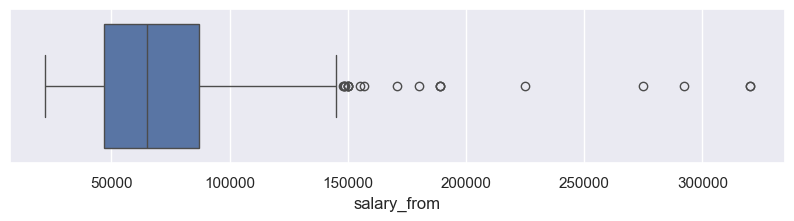

In [43]:
sns.set(rc={'figure.figsize':(10, 2)})

example = data_final[data_final.custom_position.str.contains('упаковщик')]
print(example.shape)
sns.boxplot(example.salary_from, orient='h')

(6491, 30)


<Axes: xlabel='salary_from'>

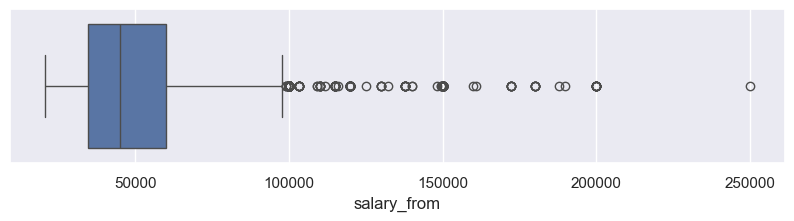

In [44]:
sns.set(rc={'figure.figsize':(10, 2)})

example = data_final[data_final.custom_position.str.contains('менеджер ')]
print(example.shape)
sns.boxplot(example.salary_from, orient='h')

(2907, 18)


<Axes: xlabel='salary_from'>

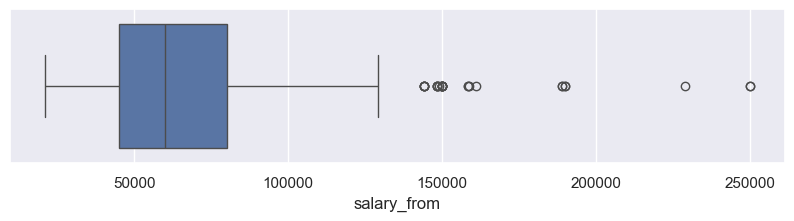

In [45]:
sns.set(rc={'figure.figsize':(10, 2)})

example = data[data.custom_position.str.contains('разнорабочий')]
print(example.shape)
sns.boxplot(example.salary_from, orient='h')